In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import functions as main
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Transform cluttered data

### Merge de todos os dados Macro num só CSV

In [ ]:
from pathlib import Path
import glob

path = r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\variables_data"
files = Path(path).glob('*.csv')  # .rglob to get subdirectories

dfs = []
for file in files:
    # Leitura do CSV
    data = pd.read_csv(file)
    
    # Ajuste do nome da coluna de datas para um nome consistente
    if 'DATE' in data.columns:
        data.rename(columns={'DATE': 'Date'}, inplace=True)
    
    if 'date' in data.columns:
        data.rename(columns={'date': 'Date'}, inplace=True)

    data["Date"] = pd.to_datetime(data.Date)

    # Definir a coluna de datas como índice
    data.set_index('Date', inplace=True)
    
    # Adicionar o DataFrame à lista
    dfs.append(data)

# Juntar todos os DataFrames usando o método "outer"
df = pd.concat(dfs, axis=1, join='outer')

In [ ]:
#df_daily = df.resample("D").last()
#df_daily_mod = df_daily.loc["2011-1-1":"2024-7-31"]

In [ ]:
df_weekly_mod = df.resample('W-FRI').last() # close semanal à sexta feira
df_weekly_mod = df_weekly_mod.loc["2011-1-1":"2024-7-31"]

In [ ]:
df_weekly_mod.info()

In [ ]:
df_weekly_mod.isna().sum()

In [ ]:
df_weekly_mod.interpolate(method='linear', inplace=True)
df_weekly_mod = df_weekly_mod.loc[df_weekly_mod.index[1]:]

In [ ]:
df_weekly_mod.isna().sum()

In [ ]:
df_weekly_mod.to_csv(f"df_weekly.csv", date_format='%Y-%m-%d')

# Descriptive analysis

In [2]:
opencsv = pd.read_csv(r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\df_weekly.csv", sep=",")
opencsv.set_index('Date', inplace=True)
opencsv.index = pd.to_datetime(opencsv.index)
opencsv = opencsv.asfreq(pd.infer_freq(opencsv.index))
opencsv = opencsv.astype(float)

In [ ]:
pd.set_option('float_format', '{:.3f}'.format)
opencsv.describe().T

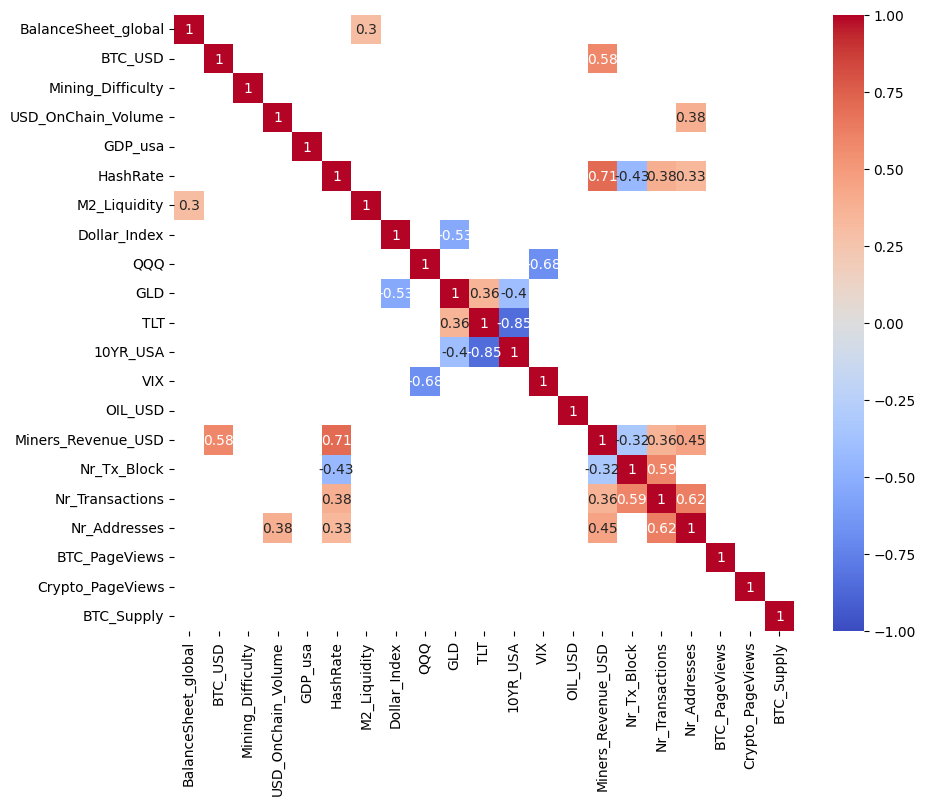

In [3]:
main.correlation_map(df=opencsv, threshold=0.3)

# OLS data Prep

In [ ]:
opencsv = pd.read_csv(r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\df_weekly.csv", sep=",")
opencsv.set_index('Date', inplace=True)
opencsv.index = pd.to_datetime(opencsv.index)
opencsv = opencsv.asfreq(pd.infer_freq(opencsv.index))
opencsv = opencsv.astype(float)

In [ ]:
opencsv.columns

### Linear trend check

In [ ]:
import plotly.express as px

def check_linearity(df, dependent_variable):
    for column in df.columns:
        if column != dependent_variable:
            df_pct_ret = df.pct_change().ffill()

            # Fazer scatter plot
            fig = px.scatter(df_pct_ret, x=df[column], y=df[dependent_variable], width=600, height=400, 
                             trendline="ols", trendline_color_override="black", title='OLS trend line')

            fig.update_layout(xaxis=dict(title=column), yaxis = dict(title=dependent_variable), template='seaborn').show()

In [ ]:
dependent_variable = "BTC_USD"

check_linearity(opencsv, dependent_variable)

## Normality Tests

In [ ]:
import seaborn as sns

btc_returns = opencsv["BTC_USD"].pct_change().dropna()
btc_log_returns = np.log10(opencsv["BTC_USD"]).diff().dropna()

f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.histplot(btc_returns,bins=40,color='r',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin returns')

ax=f.add_subplot(122)
sns.histplot(btc_log_returns,bins=40,color='b',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin returns in $log$ scale')

### Box -Cox transformation
A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests. All that we need to perform this transformation is to find lambda value and apply the rule shown below to your variable.  
$$\mathbf{ \begin {cases}\frac {y^\lambda - 1}{\lambda},& y_i\neg=0 \\
 log(y_i) & \lambda = 0 \end{cases}}$$
 The trick of Box-Cox transformation is to find lambda value, however in practice this is quite affordable. The following function returns the transformed variable, lambda value,confidence interval

In [ ]:
from scipy.stats import boxcox
BTC_USD_BoxCox,lam, ci= boxcox(opencsv["BTC_USD"],alpha=0.05)

ci,lam

In [ ]:
import seaborn as sns

# Convert numpy array to a DataFrame
BTC_USD_BoxCox_df = pd.DataFrame(BTC_USD_BoxCox, index=opencsv.index, columns=["BTC_USD_BoxCox"])

btc_BoxCox_returns = BTC_USD_BoxCox_df["BTC_USD_BoxCox"].pct_change().dropna()

f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.histplot(btc_returns,bins=40,color='r',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin returns')

ax=f.add_subplot(122)
sns.histplot(btc_BoxCox_returns,bins=40,color='b',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin Box Cox returns')

### Log Df

In [ ]:
# transformacao logaritcmica de todas as colunas

halving16 = "2016-07-09"

metade1 = opencsv.copy()
metade1 = metade1.loc[:halving16]
metade1 = metade1.drop(columns=["BTC_PageViews", "Crypto_PageViews"]) # removo porque nao tem observacoes

metade2 = opencsv.copy()
metade2 = metade2.loc[halving16:]

log_df = np.log10(metade1) 

In [ ]:
main.correlation_map(df=log_df, threshold=0.3)

In [ ]:
log_df.info()

In [ ]:
log_df.isna().sum()

### Winsorozation

In [ ]:
from scipy.stats.mstats import winsorize

winsorized_df = log_df.copy()

winsorized_df = winsorized_df.apply(lambda col: winsorize(col, (0.01, 0.01)))
winsorized_df.head()

In [ ]:
winsorized_df.shape

In [ ]:
dependent_variable = "BTC_USD"

check_linearity(winsorized_df, dependent_variable)

### Lagged variables

In [ ]:
# Add 1 and 2 Lagged Variable

lagged_df = winsorized_df.copy()

for column in lagged_df.columns:
    lagged_df[f'L1.{column}'] = lagged_df[column].shift(1)
    lagged_df[f'L2.{column}'] = lagged_df[column].shift(2)

In [ ]:
lagged_df = lagged_df.iloc[2:]
lagged_df.head(3)

In [ ]:
test_linearity_df = lagged_df.copy()
test_linearity_df = test_linearity_df.iloc[:, 19:]
test_linearity_df["BTC_USD"] = lagged_df["BTC_USD"]

#check_linearity(test_linearity_df, dependent_variable)

In [ ]:
#check_linearity(test_linearity_df, dependent_variable)

# Split cycle Dfs

In [ ]:
## ciclos
halving12 = "2012-11-28"
halving16 = "2016-07-09"
halving20 = "2020-05-11"
halving24 = "2024-04-19"

prep_df=lagged_df.copy()

ciclo1 = prep_df.loc[:halving12]
ciclo2 = prep_df.loc[halving12:halving16]
ciclo3 = prep_df.loc[halving16:halving20]
ciclo4 = prep_df.loc[halving20:halving24]
ciclo5 = prep_df.loc[halving24:]

In [ ]:
# 1 Metade
for i in range(1, 3):  # Loop from 1 to 5 to match your DataFrame names
    df = globals()[f'ciclo{i}']  # Access each DataFrame using its name
    df.to_csv(f"ciclo{i}_df.csv", date_format='%Y-%m-%d')  # Save each DataFrame with a dynamic filename

In [ ]:
# 2 Metade
for i in range(3, 6):  # Loop from 1 to 5 to match your DataFrame names
    df = globals()[f'ciclo{i}']  # Access each DataFrame using its name
    df.to_csv(f"ciclo{i}_df.csv", date_format='%Y-%m-%d')  # Save each DataFrame with a dynamic filename